<a href="https://colab.research.google.com/github/ykitaguchi77/PCAF_AI_Project/blob/main/Identify_PC_scar_from_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Identfy PC scar image from annotations**

In [ ]:
"""
PCAF_AI_Project

patient_dir = patient_dir = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Patient_1" (例)

pt1_2_0M_Photo.png --> 位置合わせをした眼底画像（2000 x 2000 px）

pt1_2_0M_Photo.txt
label cx cy wx wy track_number
0 0.724598 0.534400 0.010532 0.008982 158
0 0.720320 0.544252 0.010541 0.007405 159
0 0.722727 0.557084 0.012000 0.008595 160
0 0.709630 0.568616 0.012195 0.008414 161

このような感じでPCのアノーテーションが羅列されている。
YOLOのtrack形式。labelはすべて0で統一。
"""

In [ ]:
# prompt: gdriveに接続
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### 対応したラベルのあるpngファイルをリスト化

In [ ]:
import os
import re

patient_dir = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Patient_1"

png_files = [f for f in os.listdir(patient_dir) if f.endswith('.png')]

# Extract numbers from filenames using regular expressions
png_files.sort(key=lambda var: [int(x) if x.isdigit() else x
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])

# Filter PNG files based on corresponding TXT files
filtered_png_files = [
    png_file for png_file in png_files
    if os.path.exists(os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt'))
]

print(filtered_png_files)

['pt1_2_0M_Photo.png', 'pt1_3_1.5M_Photo.png', 'pt1_4_2Y_Photo.png', 'pt1_5_1.5M_AF.png', 'pt1_6_2Y_AF.png']


処理対象のファイル:
pt1_2_0M_Photo.png
pt1_3_1.5M_Photo.png
pt1_4_2Y_Photo.png
pt1_5_1.5M_AF.png
pt1_6_2Y_AF.png


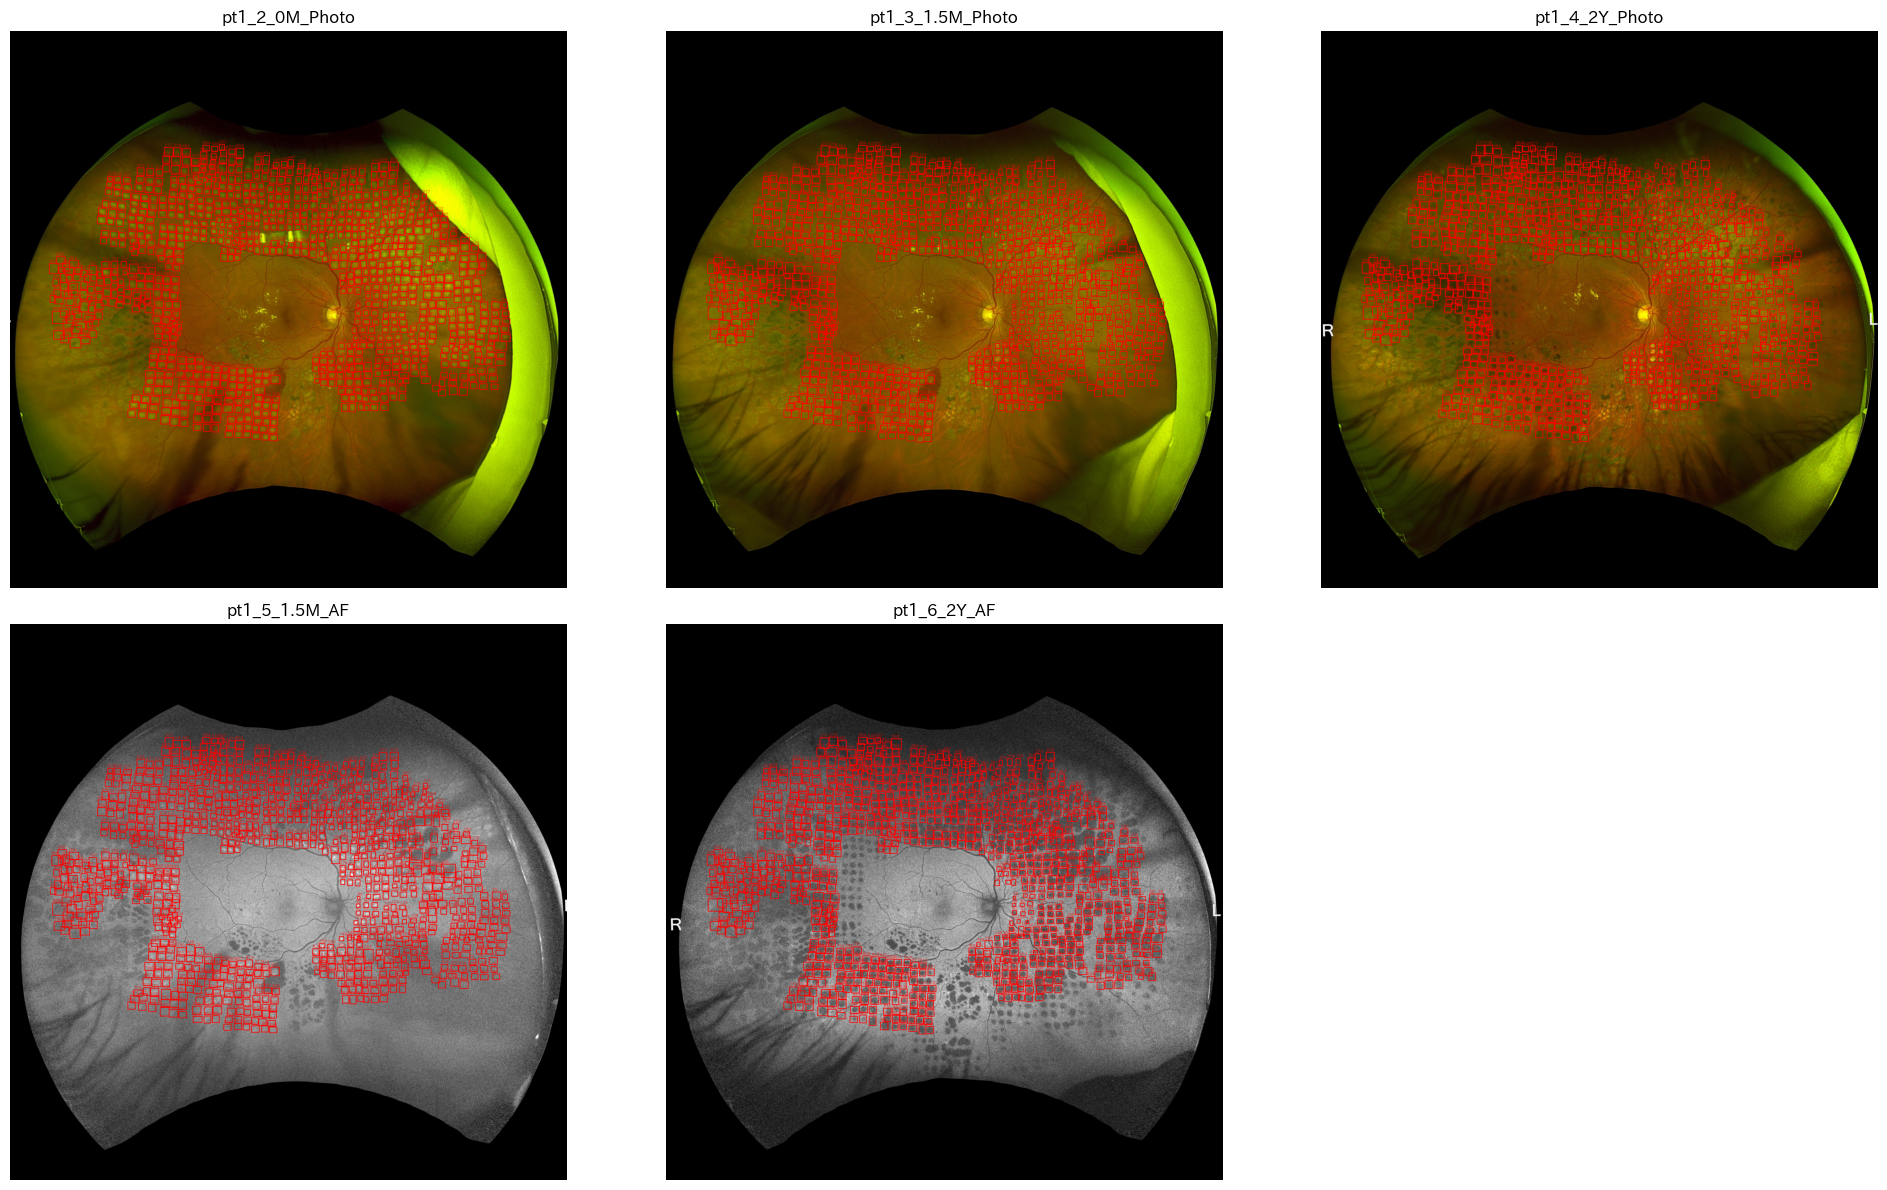

In [ ]:
# YOLOフォーマットのアノテーションを画像上に可視化するスクリプト
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from pathlib import Path

def get_filtered_png_files(patient_dir):
    """
    txtファイルが存在するpngファイルのみを取得し、ソートする
    """
    # PNGファイルを取得
    png_files = [f for f in os.listdir(patient_dir) if f.endswith('.png')]

    # ファイル名の数字でソート
    png_files.sort(key=lambda var: [int(x) if x.isdigit() else x
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])

    # 対応するTXTファイルが存在するPNGファイルのみをフィルタリング
    filtered_png_files = [
        png_file for png_file in png_files
        if os.path.exists(os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt'))
    ]

    return filtered_png_files

def visualize_annotations(patient_dir, png_files):
    """
    画像とそのアノテーションを可視化
    """
    n_images = len(png_files)
    n_cols = 3  # 1行あたりの画像数
    n_rows = (n_images + n_cols - 1) // n_cols  # 切り上げ除算

    plt.figure(figsize=(20, 6*n_rows))

    for idx, png_file in enumerate(png_files, 1):
        # 画像の読み込み
        img_path = os.path.join(patient_dir, png_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # アノテーションファイルの読み込み
        txt_path = os.path.join(patient_dir, os.path.splitext(png_file)[0] + '.txt')
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns, skiprows=1)  # ヘッダーをスキップ

        # 画像サイズの取得
        height, width = img.shape[:2]

        # バウンディングボックスの描画
        for _, row in df.iterrows():
            # 相対座標を絶対座標に変換
            x_center = int(row['cx'] * width)
            y_center = int(row['cy'] * height)
            box_width = int(row['wx'] * width)
            box_height = int(row['wy'] * height)

            # バウンディングボックスの左上と右下の座標を計算
            x1 = int(x_center - box_width/2)
            y1 = int(y_center - box_height/2)
            x2 = int(x_center + box_width/2)
            y2 = int(y_center + box_height/2)

            # バウンディングボックスを描画
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # トラッキング番号を表示
            cv2.putText(img, str(int(row['track_number'])),
                       (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                       0.5, (255, 0, 0), 1)

        # サブプロットに表示
        plt.subplot(n_rows, n_cols, idx)
        plt.imshow(img)
        plt.title(f'{os.path.splitext(png_file)[0]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # ディレクトリパスの設定
    patient_dir = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Patient_1"

    # 対象となるPNGファイルを取得
    filtered_png_files = get_filtered_png_files(patient_dir)

    print("処理対象のファイル:")
    for f in filtered_png_files:
        print(f)

    # バウンディングボックスの可視化
    visualize_annotations(patient_dir, filtered_png_files)

### ラベルの整理

In [ ]:
# テキストファイル内の各行の先頭の数字（ラベル）を0に変更するスクリプト
# 対象ファイル形式：スペース区切りのテキストファイル
# 入力例：
# label cx cy wx wy track_number
# 1 0.619445 0.563755 0.008109 0.008600 150
# 出力例：
# 0 0.619445 0.563755 0.008109 0.008600 150

import os
from tqdm import tqdm

patient_dir = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Patient_1"

# すべてのtxtファイルを取得
txt_files = [f for f in os.listdir(patient_dir) if f.endswith('.txt')]

# tqdmで進捗バーを表示
for txt_file in tqdm(txt_files, desc="ファイル処理中"):
    file_path = os.path.join(patient_dir, txt_file)

    # ファイルの内容を読み込む
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # 各行の最初の数字を0に変更
    modified_lines = []
    for line in lines:
        parts = line.split()
        if parts:  # 空行でないことを確認
            parts[0] = '0'  # 最初の数字を0に変更
            modified_lines.append(' '.join(parts) + '\n')

    # 変更した内容を書き込む
    with open(file_path, 'w') as file:
        file.writelines(modified_lines)

print("\nすべてのファイルの処理が完了しました。")

ファイル処理中: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


すべてのファイルの処理が完了しました。


In [ ]:
# 概要：
# 1. 全てのテキストファイルを走査し、トラッキング番号の出現状況を調べる
# 2. 一部のファイルにしか出現しないトラッキング番号を検出
# 3. 検出結果を表示し、ユーザーに削除の確認を取る
# 4. 確認が取れたら、該当するトラッキング番号を含む行を全ファイルから削除
#
# 入力例：
# label cx cy wx wy track_number
# 1 0.619445 0.563755 0.008109 0.008600 150
#
# 処理内容：
# - 全txtファイルの6列目(track_number)を確認
# - 全ファイルに出現しないtrack_numberを検出
# - 検出されたtrack_numberを含む行を各ファイルから削除
# - 進捗状況をtqdmで表示
# - ユーザー確認機能あり

import os
from collections import defaultdict
from tqdm import tqdm

def find_incomplete_tracking_numbers(patient_dir):
    tracking_presence = defaultdict(set)
    txt_files = [f for f in os.listdir(patient_dir) if f.endswith('.txt')]
    total_files = len(txt_files)

    print(f"全ファイル数: {total_files}")

    # 各ファイルでのトラッキング番号の出現を記録
    for txt_file in txt_files:
        file_path = os.path.join(patient_dir, txt_file)
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 6:
                    try:
                        track_number = int(parts[5])
                        tracking_presence[track_number].add(txt_file)
                    except (ValueError, IndexError):
                        continue

    # 全ファイルに出現していないトラッキング番号を抽出
    incomplete_tracking = {
        track_num: files
        for track_num, files in tracking_presence.items()
        if len(files) < total_files
    }

    return incomplete_tracking, txt_files

def display_incomplete_tracks(incomplete_tracking, total_files):
    print(f"\n全ファイルに出現していないトラッキング番号の数: {len(incomplete_tracking)}")

    # 詳細情報の表示
    print("\n===== 最初の10個の例 =====")
    for track_num, files in list(incomplete_tracking.items())[:10]:
        print(f"\nトラッキング番号: {track_num}")
        print(f"出現ファイル数: {len(files)} / {total_files}")
        print(f"出現率: {(len(files)/total_files)*100:.1f}%")

def remove_incomplete_tracks(patient_dir, incomplete_tracking_nums):
    txt_files = [f for f in os.listdir(patient_dir) if f.endswith('.txt')]

    for txt_file in tqdm(txt_files, desc="ファイル処理中"):
        file_path = os.path.join(patient_dir, txt_file)

        with open(file_path, 'r') as file:
            lines = file.readlines()

        new_lines = []
        removed_count = 0
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 6:
                try:
                    track_number = int(parts[5])
                    if track_number not in incomplete_tracking_nums:
                        new_lines.append(line)
                    else:
                        removed_count += 1
                except (ValueError, IndexError):
                    new_lines.append(line)
            else:
                new_lines.append(line)

        with open(file_path, 'w') as file:
            file.writelines(new_lines)

    return removed_count

def main():
    patient_dir = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Patient_1"

    print("不完全なトラッキング番号を検出中...\n")
    incomplete_tracking, txt_files = find_incomplete_tracking_numbers(patient_dir)

    # 検出結果の表示
    display_incomplete_tracks(incomplete_tracking, len(txt_files))

    # ユーザーに確認
    while True:
        response = input("\nこれらのトラッキング番号を含む行を削除しますか？ (yes/no): ").lower()
        if response in ['yes', 'no']:
            break
        print("'yes' または 'no' で入力してください。")

    if response == 'yes':
        print("\n削除を実行します...")
        incomplete_tracking_nums = set(incomplete_tracking.keys())
        total_removed = remove_incomplete_tracks(patient_dir, incomplete_tracking_nums)
        print(f"\n処理が完了しました。")
        print(f"削除された行の総数: {total_removed}")
    else:
        print("\n処理を中止しました。")

if __name__ == "__main__":
    main()

不完全なトラッキング番号を検出中...

全ファイル数: 5

全ファイルに出現していないトラッキング番号の数: 0

===== 最初の10個の例 =====

これらのトラッキング番号を含む行を削除しますか？ (yes/no): の
'yes' または 'no' で入力してください。

これらのトラッキング番号を含む行を削除しますか？ (yes/no): no

処理を中止しました。


#**Analyze PC scar size**

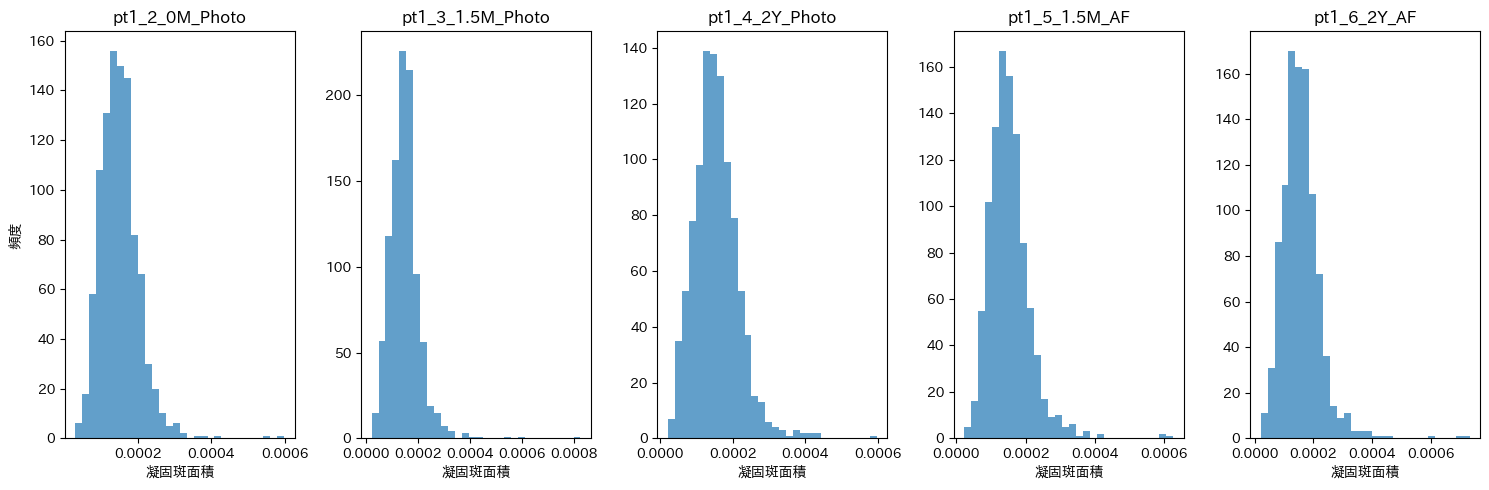

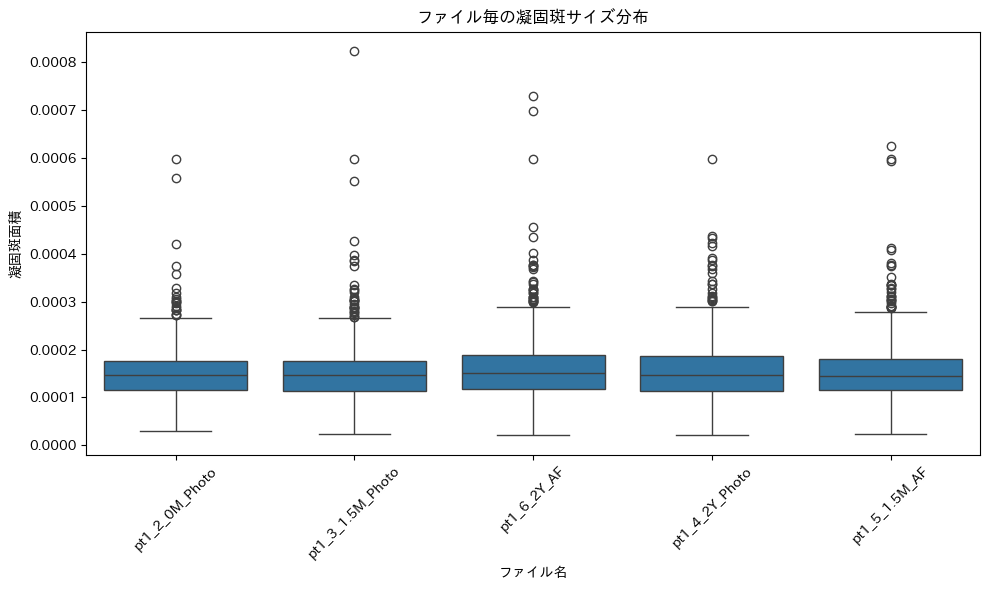


各ファイルの統計情報:
                  count      mean       std       min       25%       50%  \
file                                                                        
pt1_2_0M_Photo    998.0  0.000151  0.000053  0.000030  0.000115  0.000146   
pt1_3_1.5M_Photo  998.0  0.000150  0.000060  0.000023  0.000114  0.000146   
pt1_4_2Y_Photo    998.0  0.000154  0.000062  0.000021  0.000113  0.000148   
pt1_5_1.5M_AF     998.0  0.000153  0.000060  0.000023  0.000115  0.000146   
pt1_6_2Y_AF       998.0  0.000158  0.000066  0.000021  0.000117  0.000150   

                       75%       max  
file                                  
pt1_2_0M_Photo    0.000176  0.000597  
pt1_3_1.5M_Photo  0.000175  0.000824  
pt1_4_2Y_Photo    0.000187  0.000597  
pt1_5_1.5M_AF     0.000180  0.000625  
pt1_6_2Y_AF       0.000188  0.000729  


In [ ]:
# 凝固斑サイズの分布を可視化するスクリプト
#
# 機能:
# - 指定ディレクトリ内の全txtファイルを読み込み
# - 各凝固斑のサイズ(wx * wy)を計算
# - ヒストグラムと箱ひげ図で分布を可視化
# - 基本統計量を計算して表示
#
# 入力ファイル形式：
# label cx cy wx wy track_number
# 1 0.619445 0.563755 0.008109 0.008600 150

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from pathlib import Path
import seaborn as sns
import glob
import os

def analyze_size_distribution(patient_dir):
    """
    ディレクトリ内の全txtファイルの凝固斑サイズ分布を分析
    """
    # txtファイルを検索
    txt_files = glob.glob(os.path.join(patient_dir, '*.txt'))
    if not txt_files:
        print(f"警告: {patient_dir} 内にtxtファイルが見つかりませんでした。")
        return None

    # 全ファイルのデータを読み込み
    all_data = []
    for txt_path in txt_files:
        # データの読み込み
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns)

        # バウンディングボックスの面積を計算
        df['area'] = df['wx'] * df['wy']
        # ファイル名を追加
        df['file'] = Path(txt_path).stem
        all_data.append(df)

    # 全データを結合
    combined_df = pd.concat(all_data, ignore_index=True)

    # 1. ヒストグラムの作成（ファイル毎に並べて表示）
    plt.figure(figsize=(15, 5))
    unique_files = sorted(combined_df['file'].unique())
    n_files = len(unique_files)

    for i, file in enumerate(unique_files, 1):
        plt.subplot(1, n_files, i)
        file_data = combined_df[combined_df['file'] == file]
        plt.hist(file_data['area'], bins=30, alpha=0.7)
        plt.title(f'{file}')
        plt.xlabel('凝固斑面積')
        if i == 1:
            plt.ylabel('頻度')

    plt.tight_layout()
    plt.show()

    # 2. 箱ひげ図の作成
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='file', y='area', data=combined_df)
    plt.title('ファイル毎の凝固斑サイズ分布')
    plt.xlabel('ファイル名')
    plt.ylabel('凝固斑面積')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 基本統計量の計算
    stats = combined_df.groupby('file')['area'].describe()
    print("\n各ファイルの統計情報:")
    print(stats)

    return stats

if __name__ == "__main__":
    patient_dir = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Patient_1"
    stats = analyze_size_distribution(patient_dir)


検出されたファイル:
pt1_2_0MPhoto
pt1_3_1.5M_Photo
pt1_6_2Y_AF
pt1_4_2Y_Photo
pt1_5_1.5M_AF

実際のファイル一覧:
['pt1_2_0MPhoto', 'pt1_3_1.5M_Photo', 'pt1_4_2Y_Photo', 'pt1_5_1.5M_AF', 'pt1_6_2Y_AF']


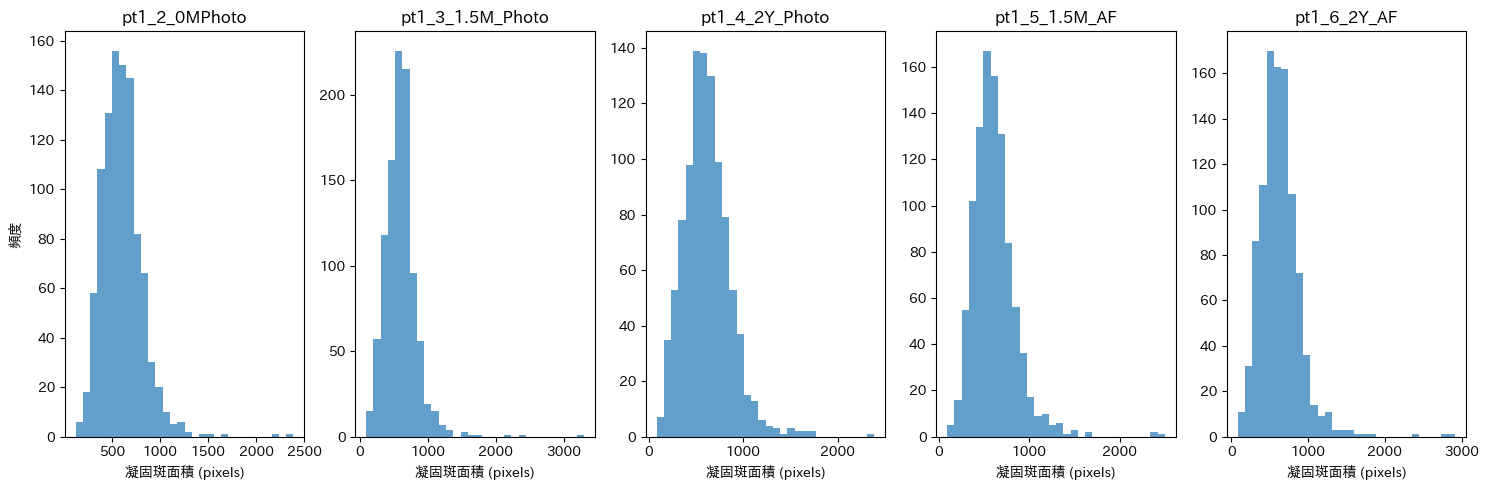

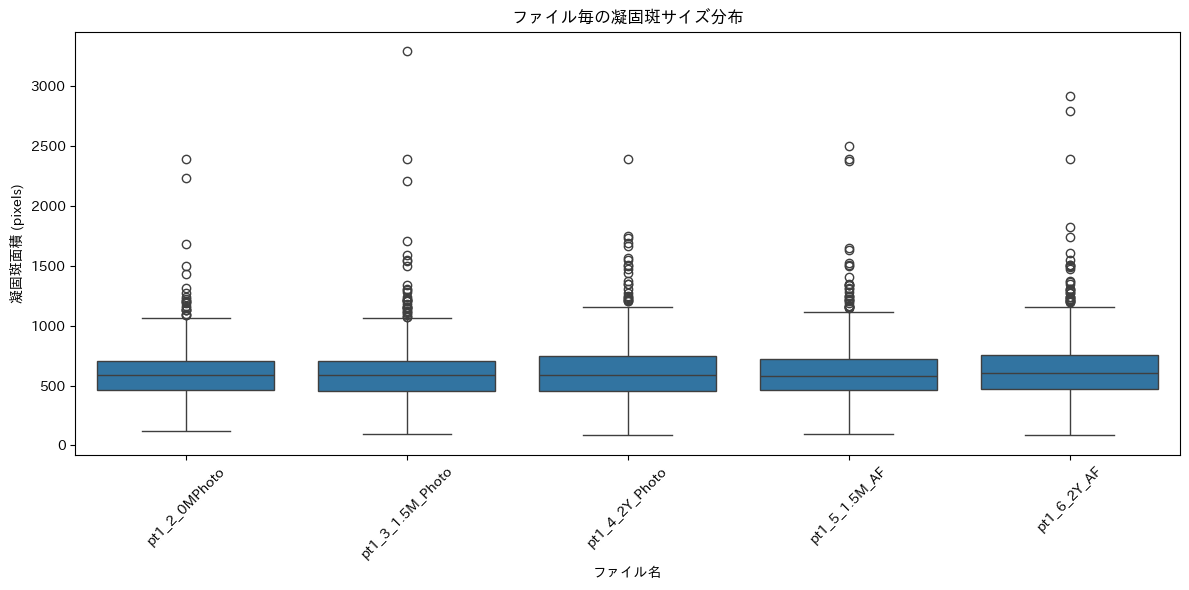


各ファイルの統計情報 (ピクセル単位):
                  count        mean         std         min         25%  \
file                                                                      
pt1_2_0MPhoto     998.0  602.604194  210.564506  121.574544  461.275200   
pt1_3_1.5M_Photo  998.0  600.544224  241.024871   91.935752  456.020379   
pt1_4_2Y_Photo    998.0  614.225791  248.957371   82.957504  453.456490   
pt1_5_1.5M_AF     998.0  612.022483  240.304762   91.935752  458.581409   
pt1_6_2Y_AF       998.0  630.792790  262.190424   82.957504  467.618085   

                        50%         75%          max  
file                                                  
pt1_2_0MPhoto     584.40032  705.975800  2388.661392  
pt1_3_1.5M_Photo  585.21779  701.498307  3294.690744  
pt1_4_2Y_Photo    591.60719  748.790519  2389.187112  
pt1_5_1.5M_AF     583.27996  721.467105  2501.970744  
pt1_6_2Y_AF       600.69621  753.373093  2917.601696  


In [ ]:
# 凝固斑サイズの分布を可視化するスクリプト（ピクセル数換算版）

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from pathlib import Path
import seaborn as sns
import glob
import os

def analyze_size_distribution(patient_dir):
    """
    ディレクトリ内の全txtファイルの凝固斑サイズ分布を分析
    """
    # txtファイルを検索
    txt_files = glob.glob(os.path.join(patient_dir, '*.txt'))
    if not txt_files:
        print(f"警告: {patient_dir} 内にtxtファイルが見つかりませんでした。")
        return None

    # 実際のファイル名を確認
    print("検出されたファイル:")
    for f in txt_files:
        print(Path(f).stem)

    # 全ファイルのデータを読み込み
    all_data = []
    for txt_path in txt_files:
        # データの読み込み
        columns = ['label', 'cx', 'cy', 'wx', 'wy', 'track_number']
        df = pd.read_csv(txt_path, sep=' ', names=columns)

        # バウンディングボックスの面積をピクセル数に換算
        df['area_pixels'] = df['wx'] * df['wy'] * 2000 * 2000
        # ファイル名を追加
        df['file'] = Path(txt_path).stem
        all_data.append(df)

    # 全データを結合
    combined_df = pd.concat(all_data, ignore_index=True)

    # 実際に存在するファイルの一覧を取得
    existing_files = sorted(combined_df['file'].unique())
    print("\n実際のファイル一覧:")
    print(existing_files)

    # 1. ヒストグラムの作成（ファイル毎に並べて表示）
    plt.figure(figsize=(15, 5))
    n_files = len(existing_files)

    for i, file in enumerate(existing_files, 1):
        plt.subplot(1, n_files, i)
        file_data = combined_df[combined_df['file'] == file]
        plt.hist(file_data['area_pixels'], bins=30, alpha=0.7)
        plt.title(f'{file}')
        plt.xlabel('凝固斑面積 (pixels)')
        if i == 1:
            plt.ylabel('頻度')

    plt.tight_layout()
    plt.show()

    # 2. 箱ひげ図の作成
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='file', y='area_pixels', data=combined_df, order=existing_files)
    plt.title('ファイル毎の凝固斑サイズ分布')
    plt.xlabel('ファイル名')
    plt.ylabel('凝固斑面積 (pixels)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 基本統計量の計算
    stats = combined_df.groupby('file')['area_pixels'].describe()
    print("\n各ファイルの統計情報 (ピクセル単位):")
    print(stats)

    return stats

if __name__ == "__main__":
    patient_dir = "/content/drive/MyDrive/Deep_learning/PCAF_AI_Project/Patient_1"
    stats = analyze_size_distribution(patient_dir)